In [199]:
# Import libraries
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import transforms, datasets

In [200]:
#Get train and test data sets from torchvision.datsets and transform to tensor form
train_data = datasets.FashionMNIST('./FMNIST', train=True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_data = datasets.FashionMNIST('./FMNIST', train=False, download = True, transform = transforms.Compose([transforms.ToTensor()]))

In [201]:
#Split data into data and targets for pre-processing
#X is images, Y is labels
trainX = train_data.data
valX = test_data.data
trainY = train_data.targets
valY = test_data.targets


#preprocess data by scaling to range from 0 to 1
#this also changes img to grayscale/255
trainX = trainX / 255.0
valX = valX / 255.0

In [202]:
#store class names for later
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#checking details
print(trainX.shape)
print(len(trainY))
print(trainY)
print(valX.shape)
print(len(valY))

torch.Size([60000, 28, 28])
60000
tensor([9, 0, 0,  ..., 3, 0, 5])
torch.Size([10000, 28, 28])
10000


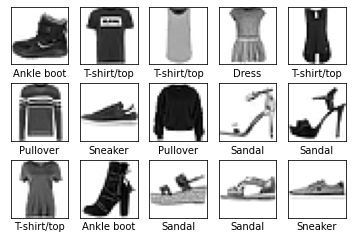

In [203]:
#verify format and check first 15 images
plt.figure(figsize=(6,4))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[trainY[i]])
plt.show()

In [204]:
#After checking images change tensors into numpy arrays and change shape to fit
#28x28=784(dimensions of fashionMNIST images) input nodes the neural network will have
trainX = trainX.reshape(60000,784).numpy()
valX = valX.reshape(10000, 784).numpy()
trainY = trainY.numpy()
valY = valY.numpy()

In [205]:
#Define desired targets by class of shopping item
zero = [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
one = [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
two = [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]
three = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
four = [0., 0., 0., 0., 1.,0., 0., 0., 0., 0.]
five = [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
six = [0., 0., 0., 0., 0., 0., 1.,0., 0., 0.]
seven = [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]
eight = [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]
nine = [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]

#convert training and testing targets to an array to make calculation more simple
#first save to a list, then convert to an array
trainY_temp = []
for i in range(len(trainY)):
    if trainY[i] == 0:
        trainY_temp.append(zero)
    elif trainY[i] == 1:
        trainY_temp.append(one)
    elif trainY[i] == 2:
        trainY_temp.append(two)
    elif trainY[i] == 3:
        trainY_temp.append(three)
    elif trainY[i] == 4:
        trainY_temp.append(four)
    elif trainY[i] == 5:
        trainY_temp.append(five)
    elif trainY[i] == 6:
        trainY_temp.append(six)
    elif trainY[i] == 7:
        trainY_temp.append(seven)
    elif trainY[i] == 8:
        trainY_temp.append(eight)
    elif trainY[i] == 9:
        trainY_temp.append(nine)
        
valY_temp = []
for i in range(len(valY)):
    if valY[i] == 0:
        valY_temp.append(zero)
    elif valY[i] == 1:
        valY_temp.append(one)
    elif valY[i] == 2:
        valY_temp.append(two)
    elif valY[i] == 3:
        valY_temp.append(three)
    elif valY[i] == 4:
        valY_temp.append(four)
    elif valY[i] == 5:
        valY_temp.append(five)
    elif valY[i] == 6:
        valY_temp.append(six)
    elif valY[i] == 7:
        valY_temp.append(seven)
    elif valY[i] == 8:
        valY_temp.append(eight)
    elif valY[i] == 9:
        valY_temp.append(nine)

#Convert to numpy array
trainY = np.array(trainY_temp)
valY = np.array(valY_temp)

In [206]:
#Deep Nueral Network class
class DeepNeuralNetwork():    
#Initialise class. all parameters can be changed here:
#number of units and number and type of layers(in activation functions)
    def __init__(self, sizes=[784, 64, 64, 10], activation_functions=['sigmoid', 'relu', 'softmax'], epochs=10, l_rate=0.01):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.activation_functions = activation_functions

#save all parameters in this dictionary. 
        self.params = self.initialization()

#Sigmoid layer
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

#Relu layer
    def relu(self, x, derivative=False):
            if derivative:
                copy = np.array(x, copy = True)
                copy[x <= 0] = 0
                copy[x > 0] = 1
                return copy
            return np.maximum(0,x)

#Softmax layer
    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)


#This function initializes the weights of nodes
    def initialization(self):
        
#dictionary to save parameters
        params = dict()
#Loops through sizes
        for index in range(len(self.sizes)):
#Stopping condition
            if index != (len(self.sizes)-1):
            
                params['W' + str(index + 1)] = np.random.randn(self.sizes[index+1], self.sizes[index])* np.sqrt(1. / self.sizes[index+1])       

        return params

#Forward pass the data through the deep neural network 
    def forward_pass(self, trainX):
#Get parameters in the memory 
        params = self.params
#Get activation functions
        activation_function = self.activation_functions
#Set initial inputs as training data
        params['A0'] = trainX
#Loop through the multiple layers
        for index in range(len(self.sizes)):
#Stopping criteria
            if(index != (len(self.sizes)-1)):
#Get type of layers used
                if activation_function[index] == 'sigmoid':
                    activation = self.sigmoid
                elif activation_function[index] == 'relu':
                    activation = self.relu
                elif activation_function[index] == 'softmax':
                    activation = self.softmax
                else:
                    print('other layers not supported')
                
                params['B' + str(index+1)] = np.dot(params['W' + str(index+1)], params['A' + str(index)])
                params['A' + str(index+1)] = activation(params['B' + str(index+1)])
        
#Returns last value to update params
        last_value = str(list(params)[-1])
        return params[last_value]
    
#This function passes the data backwards to calculate updates to neural network parameters
    def backward_pass(self, trainY, output):
#Get parameters in the memory 
        params = self.params
#Get activation functions
        activation_function = self.activation_functions
#dictionary to save W change
        change_w = dict()
        
#Go through the layers in reverse
        for index in reversed(range(len(self.sizes))):
#Stopping Condition 
            if(index != 0):
#Get type of layer types
                if activation_function[index-1] == 'sigmoid':
                    activation = self.sigmoid
                elif activation_function[index-1] == 'relu':
                    activation = self.relu
                elif activation_function[index-1] == 'softmax':
                    activation = self.softmax
                else:
                    print('other layers not supported')
                
#Get change from output layer
                if index == (len(self.sizes) - 1):    
                    error = 2 * (output - trainY) / output.shape[0] * activation(params['B' + str(index)], derivative=True)
                    change_w['W' + str(index)] = np.outer(error, params['A' + str(index-1)])
#Get change from hidden layers
                else:
                    error = np.dot(params['W' + str(index+1)].T, error) * activation(params['B' + str(index)], derivative=True)
                    change_w['W' + str(index)] = np.outer(error, params['A' + str(index-1)])

        return change_w
    
#use Stochastic Gradient Descent (SGD) optimizer
#update parameters according to update rule from SGD
    def update_network_parameters(self, changes_to_w):        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value
            
#Calculates accuracy
    def compute_accuracy(self, x_val, y_val):
        predictions = []
#Compare output value to target
        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
#Get mean
        return np.mean(predictions)
#function to train deep neural network
    def train(self, trainX, trainY, x_val, y_val):
#Record start time
        start_time = time.time()
#Loop through epochs as specified in intialiser of class above (__init__)
        for iteration in range(self.epochs):
            for x,y in zip(trainX, trainY):
#Forward pass trainig data through the network
                output = self.forward_pass(x)
#Backward pass data and find error
                changes_to_w = self.backward_pass(y, output)
#update parameters
                self.update_network_parameters(changes_to_w)
#Display accuracy and time spent per epoch
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))

In [207]:
# Call neural network function
dnn = DeepNeuralNetwork()
# Train the network using the data
dnn.train(trainX, trainY, valX, valY)

Epoch: 1, Time Spent: 29.06s, Accuracy: 72.53%
Epoch: 2, Time Spent: 55.93s, Accuracy: 76.64%
Epoch: 3, Time Spent: 83.80s, Accuracy: 79.70%
Epoch: 4, Time Spent: 111.14s, Accuracy: 81.15%
Epoch: 5, Time Spent: 137.86s, Accuracy: 81.80%
Epoch: 6, Time Spent: 164.64s, Accuracy: 82.31%
Epoch: 7, Time Spent: 193.62s, Accuracy: 82.83%
Epoch: 8, Time Spent: 220.04s, Accuracy: 83.15%
Epoch: 9, Time Spent: 247.06s, Accuracy: 83.28%
Epoch: 10, Time Spent: 275.56s, Accuracy: 83.31%
